In [2]:
!pip install wordcloud

In [75]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.4 MB/s eta 0:00:00


In [3]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=94ad218a41a566899b7d6007888fc73bc7f8d0cec66f891528f9db001de155d8
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from string import punctuation
from spacy.lang.en import stop_words

In [96]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
stop_words = stop_words.STOP_WORDS

In [7]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
train_df = pd.read_csv("train.csv", encoding="latin1")
train_df.head()

ID  RecipeNumber  RecipeCode                              RecipeName  \
0   70            71       12259  Banana Bars with Cream Cheese Frosting   
1   72            88        8202                        Simple Taco Soup   
2  458             3        2832                       Cheeseburger Soup   
3    7            50      100276               Grilled Huli Huli Chicken   
4   60            12       19731                        Cauliflower Soup   

                     CommentID                         UserID        UserName  \
0   sp_aUSaElGf_12259_c_149978  u_1oKVaBmiEKwAFyiHrDLoWpbel0J   misscoffeepot   
1    sp_aUSaElGf_8202_c_310332  u_1oKZeRIXYzGNhGW8OMR3O4lX1ih  MichelleMalone   
2    sp_aUSaElGf_2832_c_206522  u_1oKYHUtdaD48KJCDYq5wfpAUxWz       jeannem32   
3  sp_aUSaElGf_100276_c_434088  u_1oKZCQcKQZdQhDVBS7oISc216VA           ds422   
4   sp_aUSaElGf_19731_c_387011  u_1oKd4sudZQPgu6YALiC7bW7mKMs     SusanHoward   

   UserReputation  CreationTimestamp  ReplyCount  ThumbsUpCount  \
0              20         1622717078           0              0   
1               1         1622717852           0              0   
2               1         1622717357           0              0   
3               1         1622648899           0              0   
4               1         1622718260           0              0   

   ThumbsDownCount  BestScore  \
0                0        100   
1                1        100   
2                0        100   
3                0        100   
4                0        100   

                                       Recipe_Review  Rating  
0  great recipe! I have made them just as written...       5  
1  This is an easy and quick recipe that is great...       5  
2  I think I was looking for something extra spec...       3  
3  This is our favorite grilled chicken recipe.  ...       5  
4  Great basic recipe. I added 2 teaspoons Tuscan...       4

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13738 entries, 0 to 13737
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13738 non-null  int64 
 1   RecipeNumber       13738 non-null  int64 
 2   RecipeCode         13738 non-null  int64 
 3   RecipeName         13738 non-null  object
 4   CommentID          13738 non-null  object
 5   UserID             13738 non-null  object
 6   UserName           13738 non-null  object
 7   UserReputation     13738 non-null  int64 
 8   CreationTimestamp  13738 non-null  int64 
 9   ReplyCount         13738 non-null  int64 
 10  ThumbsUpCount      13738 non-null  int64 
 11  ThumbsDownCount    13738 non-null  int64 
 12  BestScore          13738 non-null  int64 
 13  Recipe_Review      13736 non-null  object
 14  Rating             13738 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [10]:
train_df.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review',
       'Rating'],
      dtype='object')

In [11]:
cols = train_df.columns
num_cols = [column for column in train_df.columns if train_df[column].dtype == "int64"]
cat_cols = [column for column in train_df.columns if train_df[column].dtype == "object"]

In [12]:
num_cols

['ID',
 'RecipeNumber',
 'RecipeCode',
 'UserReputation',
 'CreationTimestamp',
 'ReplyCount',
 'ThumbsUpCount',
 'ThumbsDownCount',
 'BestScore',
 'Rating']

In [13]:
cat_cols

['RecipeName', 'CommentID', 'UserID', 'UserName', 'Recipe_Review']

In [14]:
train_df[num_cols].describe()

ID  RecipeNumber     RecipeCode  UserReputation  \
count  13738.000000  13738.000000   13738.000000    13738.000000   
mean     120.850924     38.674843   21742.961858        2.156063   
std      116.787463     29.677474   23897.591096       10.050964   
min        0.000000      1.000000     386.000000        0.000000   
25%       45.000000     12.000000    6504.000000        1.000000   
50%       91.000000     33.000000   14600.000000        1.000000   
75%      148.000000     63.000000   32535.000000        1.000000   
max      724.000000    100.000000  191775.000000      510.000000   

       CreationTimestamp    ReplyCount  ThumbsUpCount  ThumbsDownCount  \
count       1.373800e+04  13738.000000   13738.000000     13738.000000   
mean        1.623715e+09      0.014704       1.100015         0.558305   
std         5.451620e+06      0.137848       4.172454         3.316458   
min         1.613035e+09      0.000000       0.000000         0.000000   
25%         1.622717e+09      0.000000       0.000000         0.000000   
50%         1.622718e+09      0.000000       0.000000         0.000000   
75%         1.622718e+09      0.000000       0.000000         0.000000   
max         1.665756e+09      3.000000      80.000000       126.000000   

          BestScore        Rating  
count  13738.000000  13738.000000  
mean     153.000437      4.271728  
std      140.754093      1.551584  
min        0.000000      0.000000  
25%      100.000000      5.000000  
50%      100.000000      5.000000  
75%      100.000000      5.000000  
max      946.000000      5.000000

<Axes: xlabel='Rating', ylabel='Count'>

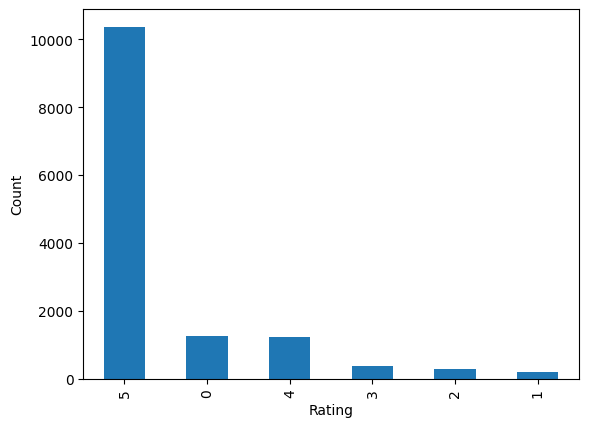

In [15]:
train_df.Rating.value_counts().plot(kind="bar", ylabel="Count")

<Axes: xlabel='UserReputation', ylabel='Count'>

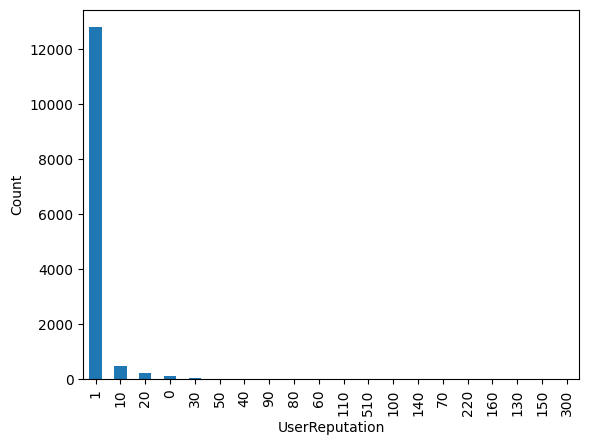

In [16]:
train_df["UserReputation"].value_counts().plot(kind="bar", ylabel="Count")

In [17]:
len(train_df["UserID"].unique())

10807

In [18]:
len(train_df["UserName"].unique())

10635

In [20]:
train_df["Recipe_Review"] = train_df["Recipe_Review"].fillna("")

In [21]:
train_df["review_len"] = train_df["Recipe_Review"].apply(lambda x: len(x))
train_df["review_len"]

0        262
1        406
2        150
3         60
4        135
        ... 
13733     80
13734    162
13735    245
13736    422
13737     61
Name: review_len, Length: 13738, dtype: int64

<Axes: xlabel='UserReputation', ylabel='review_len'>

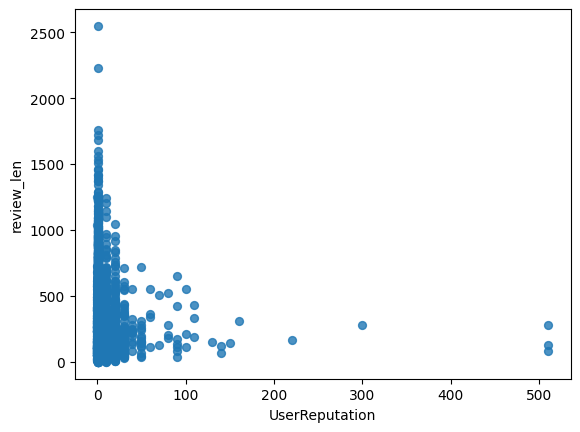

In [22]:
train_df.plot(kind='scatter', x='UserReputation', y='review_len', s=32, alpha=.8)

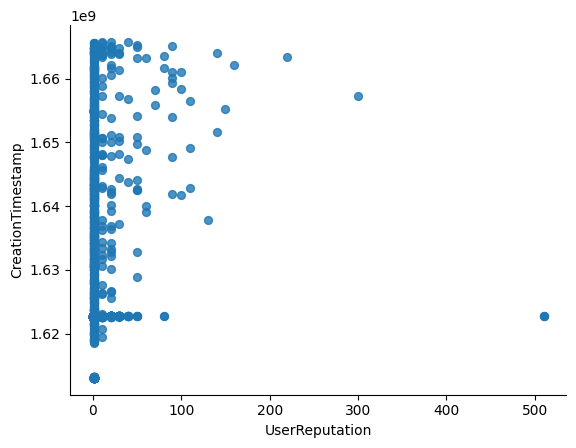

In [23]:
train_df.plot(kind='scatter', x='UserReputation', y='CreationTimestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [24]:
train_df["datetime"] = pd.to_datetime(train_df["CreationTimestamp"], unit="s")

<Axes: xlabel='Hour (24 H)', ylabel='Count'>

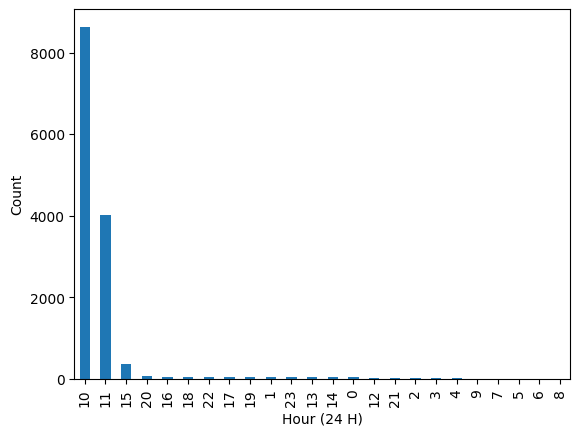

In [25]:
train_df["datetime"].dt.hour.value_counts().plot(kind="bar", ylabel="Count", xlabel="Hour (24 H)")

<Axes: xlabel='Day', ylabel='count'>

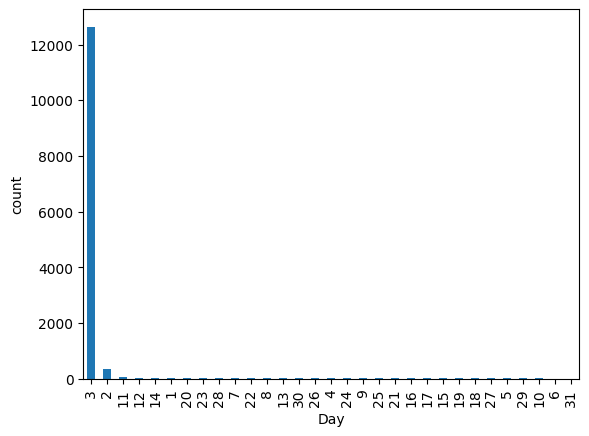

In [26]:
train_df["datetime"].dt.day.value_counts().plot(kind="bar", ylabel="count", xlabel="Day")

<Axes: xlabel='month', ylabel='count'>

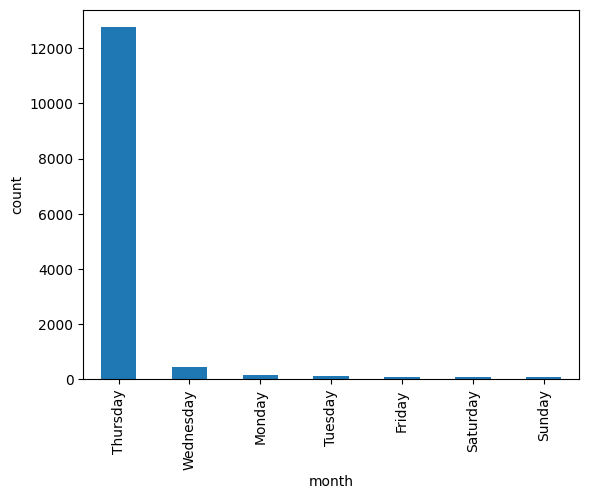

In [27]:
train_df["datetime"].dt.day_name().value_counts().plot(kind="bar", ylabel="count", xlabel="month")

<Axes: xlabel='month', ylabel='count'>

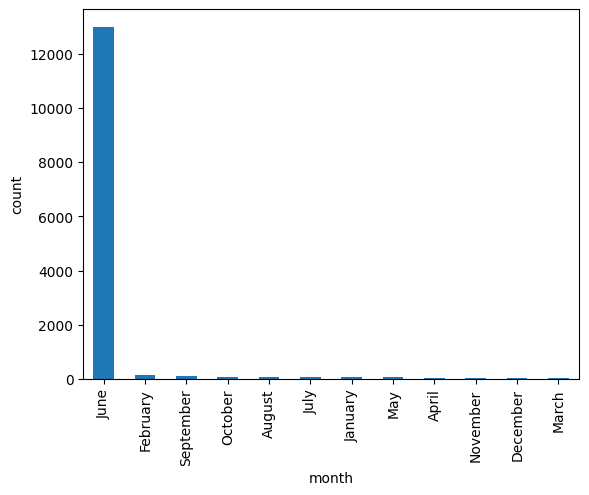

In [28]:
train_df["datetime"].dt.month_name().value_counts().plot(kind="bar", ylabel="count", xlabel="month")

In [29]:
sent = nlp("My name is Sample Name!")

In [30]:
print("POS Tagging")
[f"{word}: {word.pos_}" for word in sent]

POS Tagging


['My: PRON',
 'name: NOUN',
 'is: AUX',
 'Sample: PROPN',
 'Name: PROPN',
 '!: PUNCT']

In [31]:
print("Lemmatizing")
[f"{word}: {word.lemma_}" for word in sent]

Lemmatizing


['My: my', 'name: name', 'is: be', 'Sample: Sample', 'Name: Name', '!: !']

In [32]:
" ".join(f"{word=}: {word.lemma_=}" for word in sent)

"word=My: word.lemma_='my' word=name: word.lemma_='name' word=is: word.lemma_='be' word=Sample: word.lemma_='Sample' word=Name: word.lemma_='Name' word=!: word.lemma_='!'"

In [33]:
def pre_process(sentence):
  nlp_object = nlp(sentence)
  cleaned_list = " ".join([word.lemma_.lower().strip() for word in nlp_object if word not in stop_words])
  return cleaned_list

In [61]:
processed_sentences = train_df["RecipeName"].parallel_apply(pre_process)

In [65]:
processed_sentences_reviews = train_df["Recipe_Review"].parallel_apply(pre_process)

In [67]:
processed_sentences_reviews[0]

'great recipe ! i have make they just as write , wonderfull , moist , delicate flavor ... then the next time , i do not have sour cream so use vanilla yogurt and add toffee pieces- still good .  i have make they as cupcake and they rise very nicely and stay moist .'

In [34]:
from wordcloud import WordCloud

In [60]:
def gen_wordcloud(df: pd.DataFrame, col_filter: str, value : int, text_col: str, filter_word_list : list = None) -> None:
  """
  This function creates wordcloud of a categorical column based on some filter columns

  Args:
    df: The dataframe containing all the required columns
    col_filter: The column name based on which we will filter
    value: The value of the column 'col_filter' based on which we will filter
    text_col: The categorical column which will be used to plot the wordcloud
    filter_word_list: The list of words which will be omitted while generating the wordcloud

  Return:
    None
  """

  text_list = df[df[col_filter] == value][text_col].parallel_apply(pre_process)
  text = " ".join(text_list)

  if filter_word_list:
    for word in filter_word_list:
      text = text.replace(word, "")

  wordcloud = WordCloud(width = 1600, height = 800,
                        background_color ='black',
                        min_font_size = 10).generate(text)
  plt.figure(figsize = (12, 12), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()



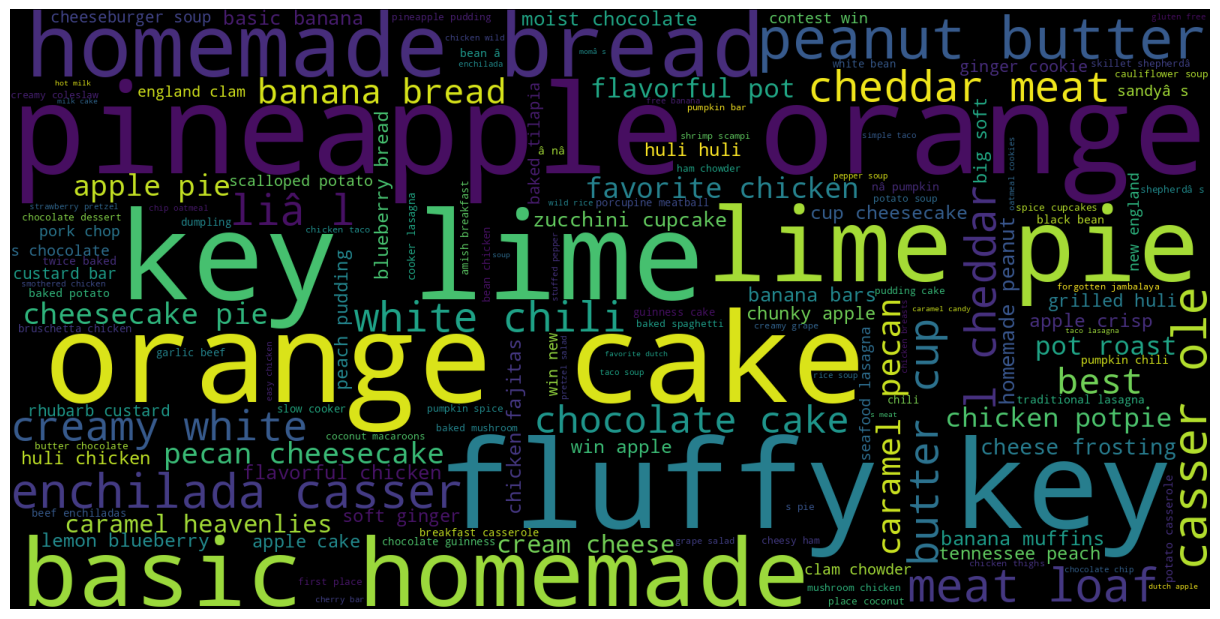

In [62]:
gen_wordcloud(df=train_df, col_filter="Rating", value=0, text_col="RecipeName")

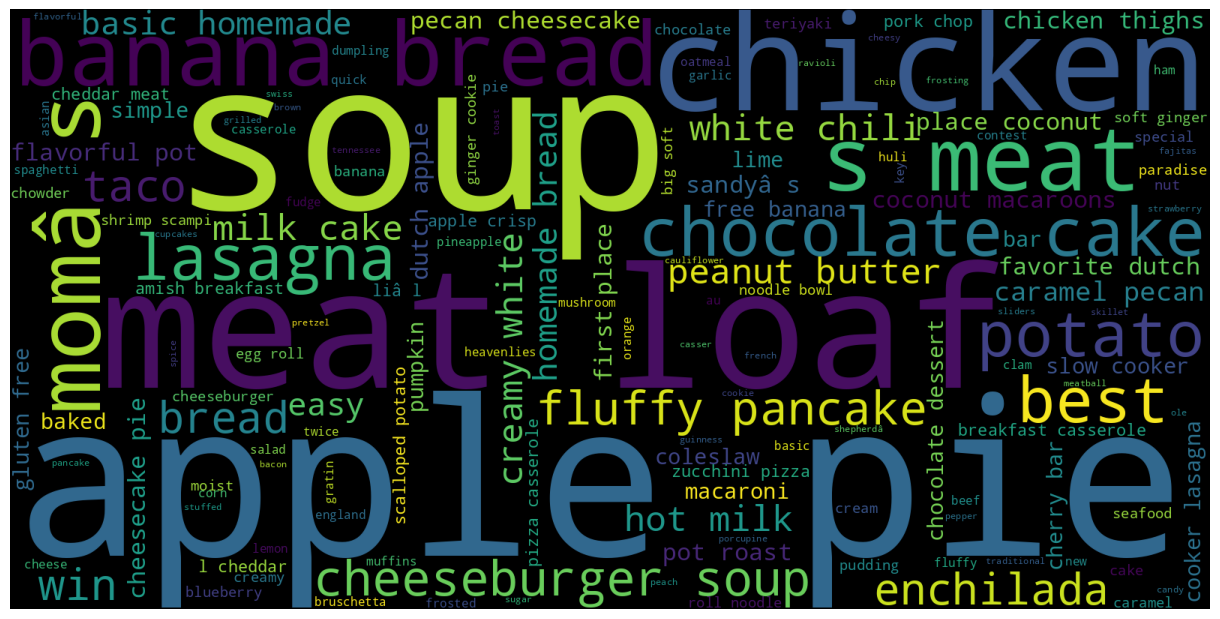

In [61]:
gen_wordcloud(df=train_df, col_filter="Rating", value=1, text_col="RecipeName")

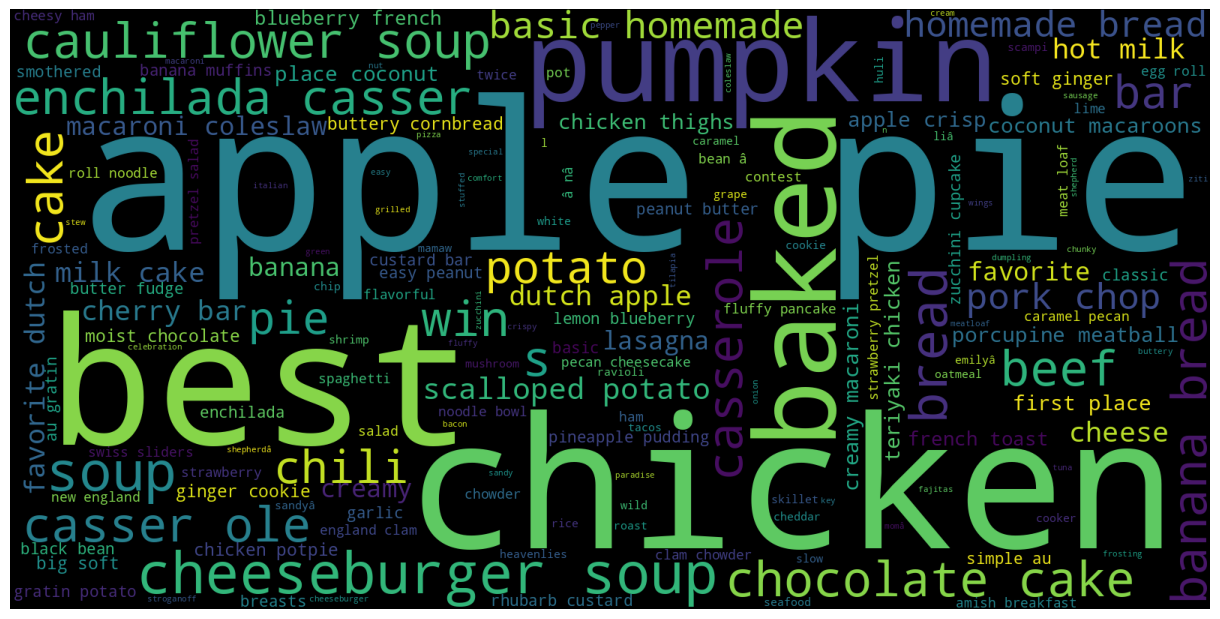

In [63]:
gen_wordcloud(df=train_df, col_filter="Rating", value=2, text_col="RecipeName")

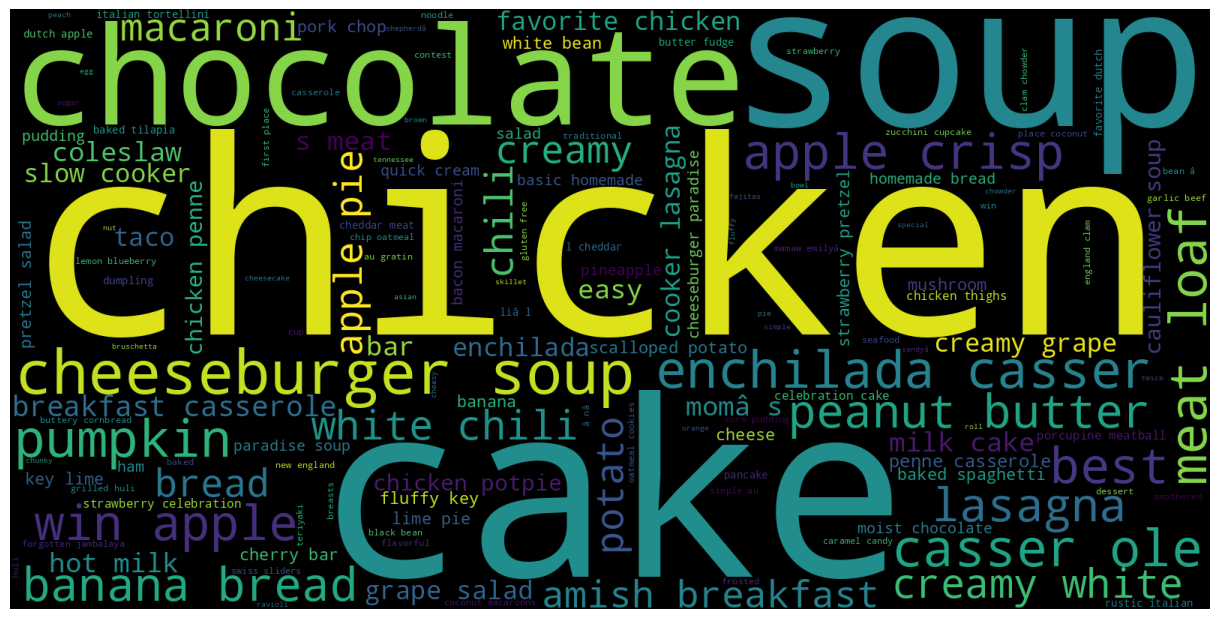

In [64]:
gen_wordcloud(df=train_df, col_filter="Rating", value=3, text_col="RecipeName")

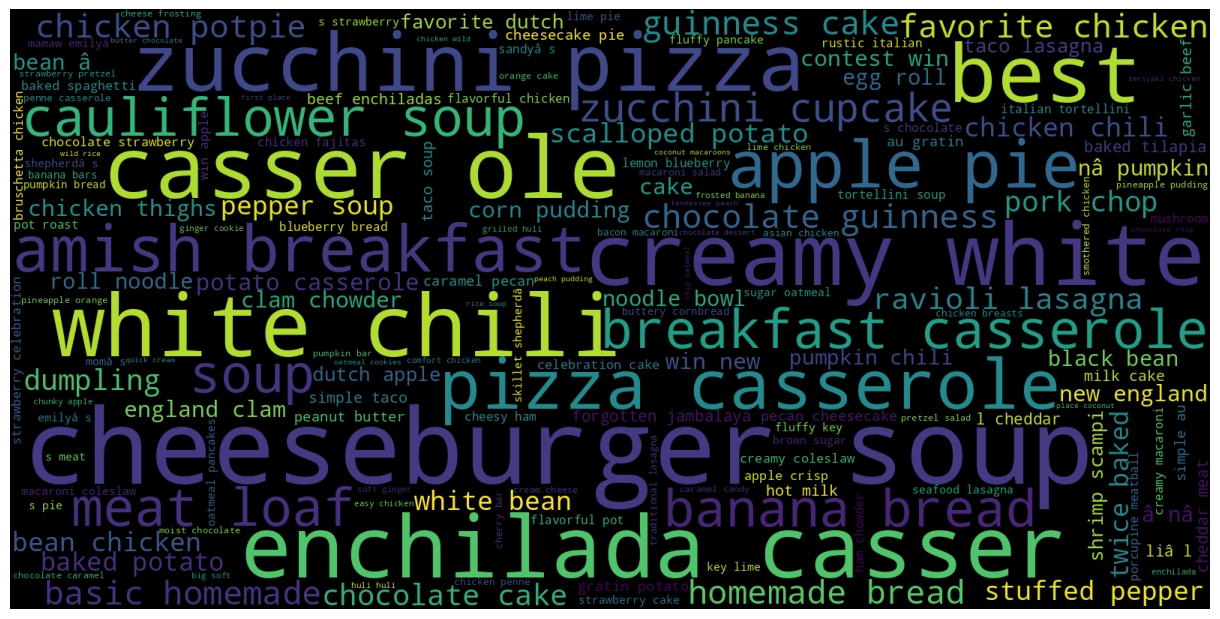

In [65]:
gen_wordcloud(df=train_df, col_filter="Rating", value=4, text_col="RecipeName")

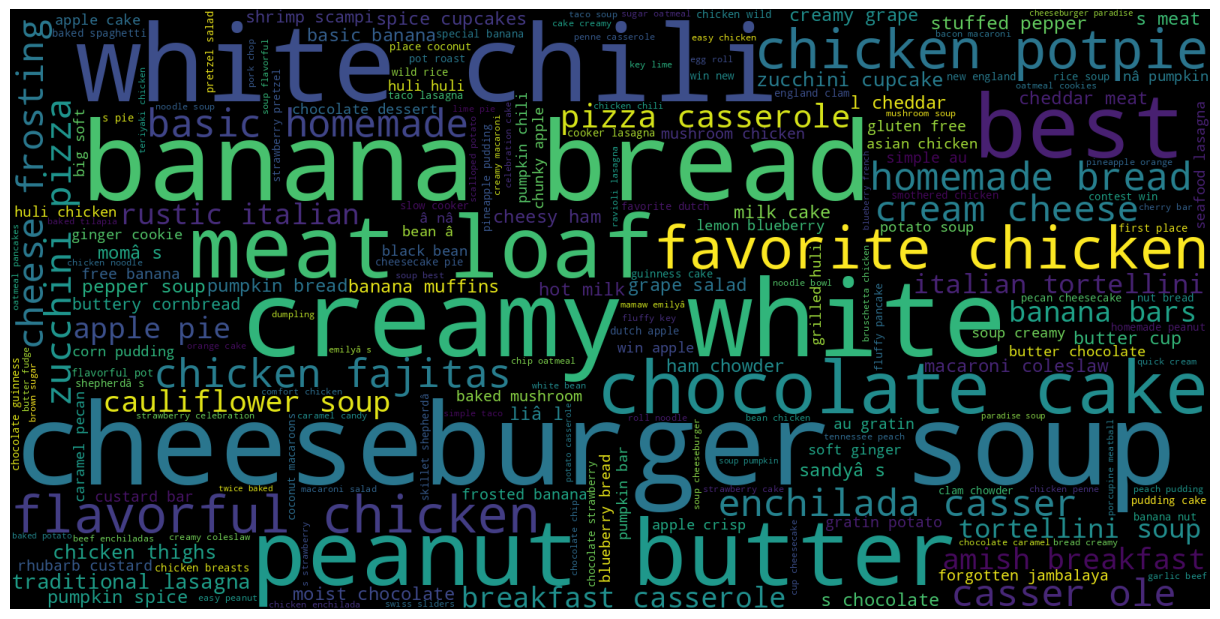

In [66]:
gen_wordcloud(df=train_df, col_filter="Rating", value=5, text_col="RecipeName")

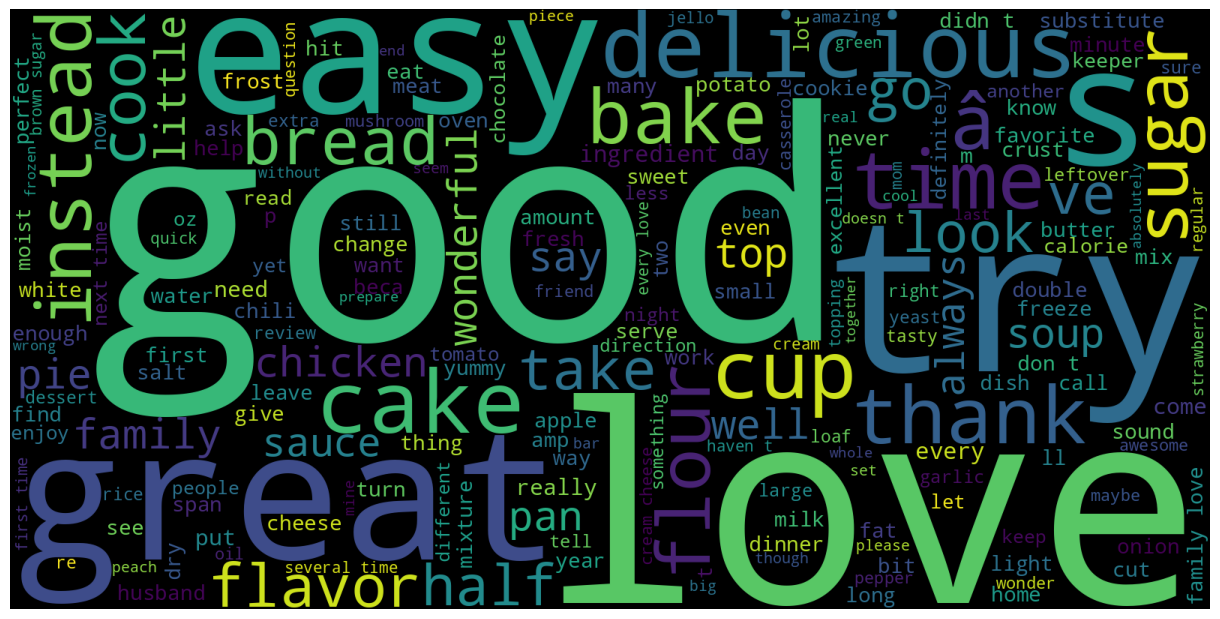

In [67]:
gen_wordcloud(df=train_df, col_filter="Rating", value=0, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

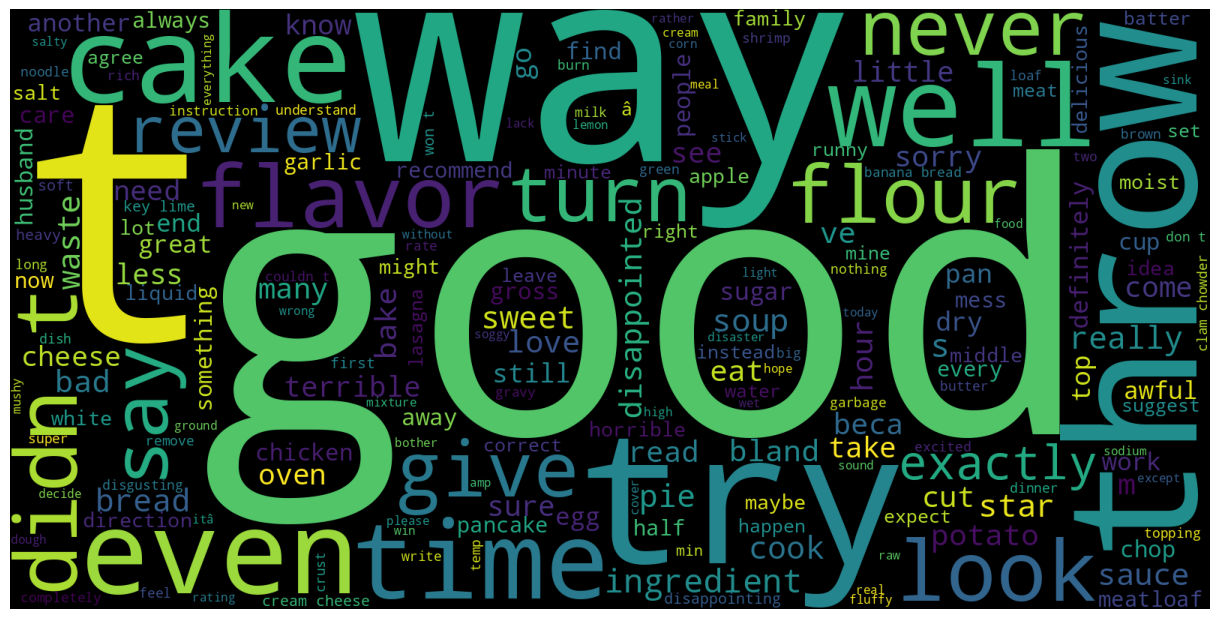

In [68]:
gen_wordcloud(df=train_df, col_filter="Rating", value=1, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

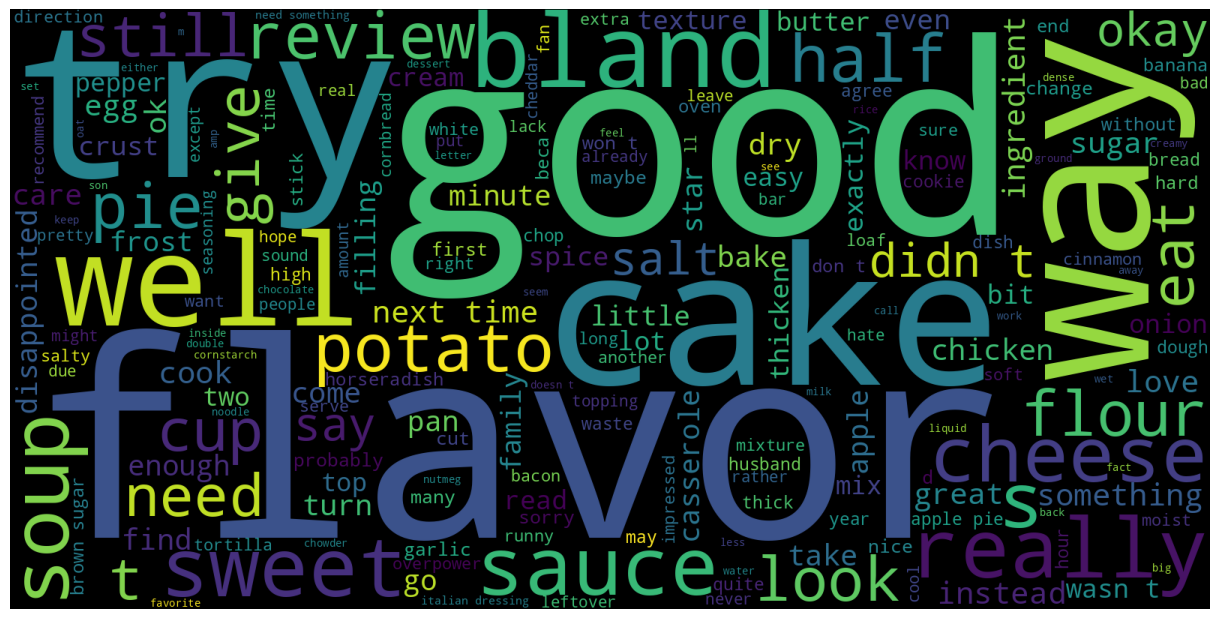

In [69]:
gen_wordcloud(df=train_df, col_filter="Rating", value=2, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

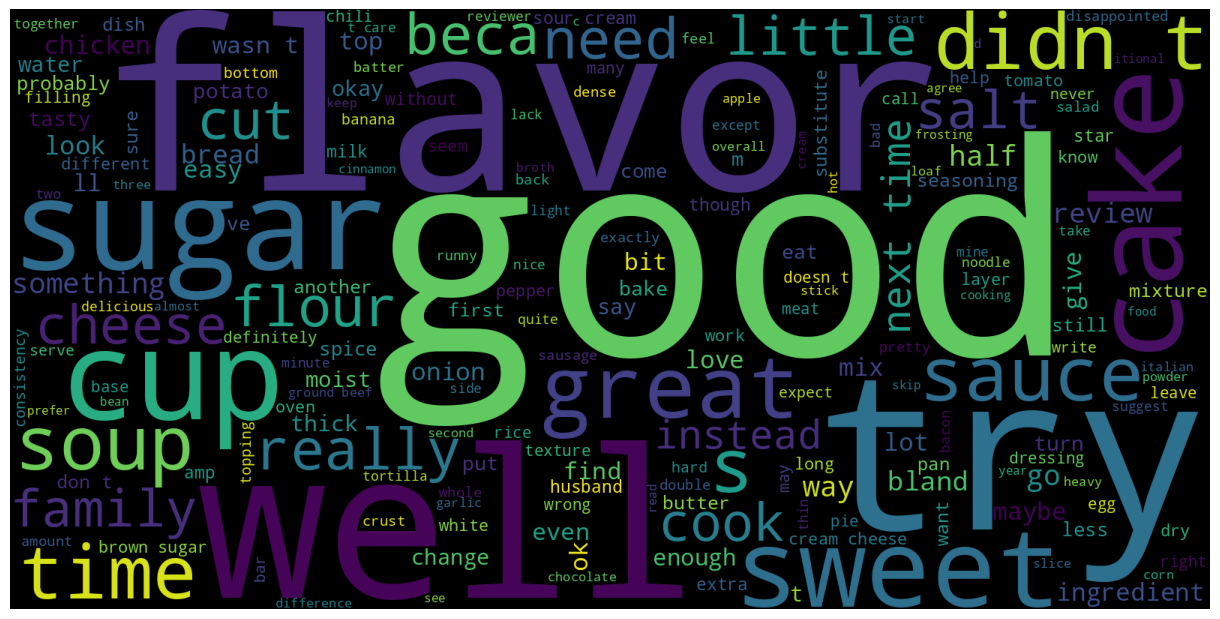

In [70]:
gen_wordcloud(df=train_df, col_filter="Rating", value=3, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

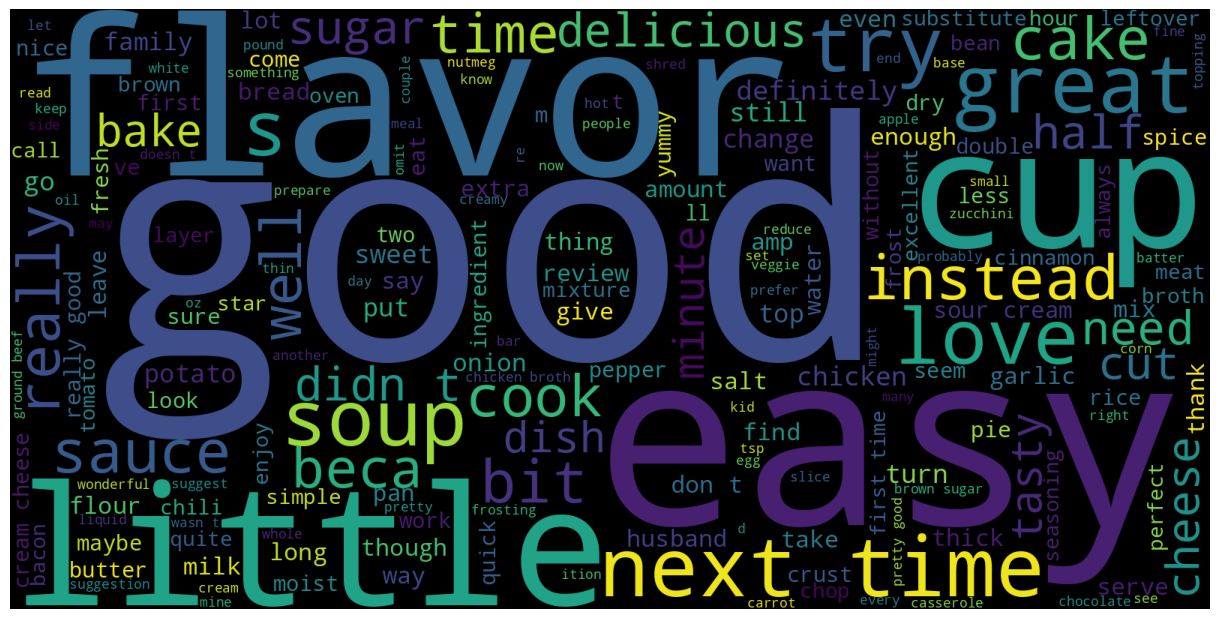

In [71]:
gen_wordcloud(df=train_df, col_filter="Rating", value=4, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

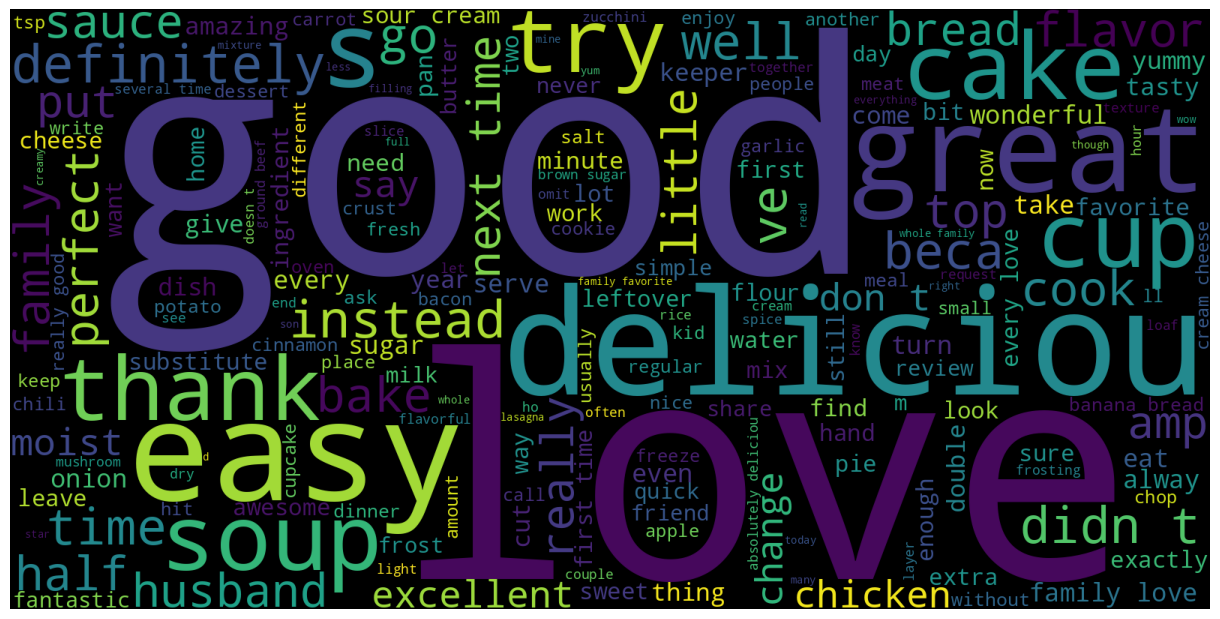

In [72]:
gen_wordcloud(df=train_df, col_filter="Rating", value=5, text_col="Recipe_Review",
              filter_word_list = ["use", "add", "make", "recipe", "taste", "think", "follow", "much", "one", "will"])

In [88]:
model = pickle.load(open("model_catboost.pkl", "rb"))

In [90]:
df = pd.read_csv("train.csv", encoding="latin1")

In [91]:
df["Recipe_Review"] = df["Recipe_Review"].fillna("")
target = df["Rating"]
df = df.drop("Rating", axis=1)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    df, target, test_size=0.1, random_state=42
)

In [106]:
y_pred = model.predict(X_test)

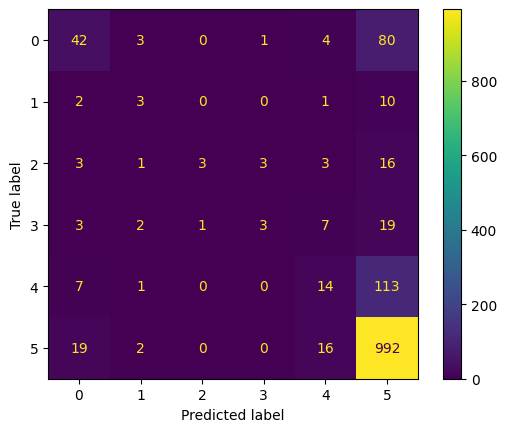

In [107]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [108]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.553     0.323     0.408       130
           1      0.250     0.188     0.214        16
           2      0.750     0.103     0.182        29
           3      0.429     0.086     0.143        35
           4      0.311     0.104     0.156       135
           5      0.807     0.964     0.878      1029

    accuracy                          0.769      1374
   macro avg      0.516     0.295     0.330      1374
weighted avg      0.717     0.769     0.722      1374



In [115]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are your test labels and predicted labels respectively
# And n_classes is the number of unique classes in your labels

# Binarize the output labels for precision-recall and ROC curves
classes = sorted(list(set(y_test)))
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))


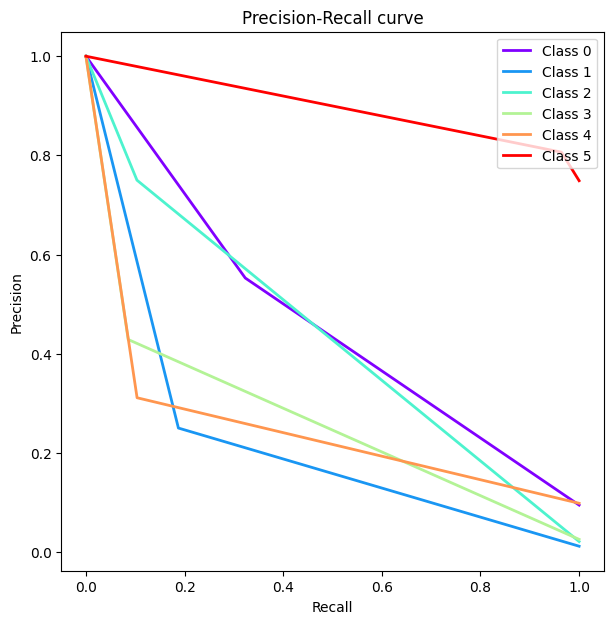

In [116]:
plt.figure(figsize=(7, 7))
for i, color in zip(range(len(classes)), colors):
    # Compute Precision-Recall curve and area for each class
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, color=color, lw=2, label='Class %d' % i)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.title('Precision-Recall curve')
plt.show()

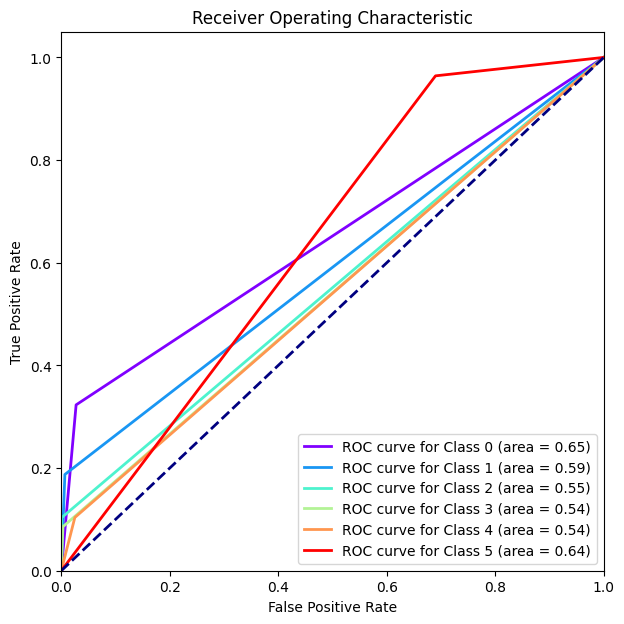

In [117]:
plt.figure(figsize=(7, 7))
for i, color in zip(range(len(classes)), colors):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve for Class %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()